<a href="https://colab.research.google.com/github/sebastian-jarosz/pandas_laboratory/blob/main/Uczenie_Maszynowe_Lab_Cw3_Jarosz_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4431872/4422102 [==============================] - 0s 0us/step
[0.0, 0.1866769790649414, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8133230209350586, 0.0, 0.0]
[0.7723109722137451, 0.0, 0.22768902778625488, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.387019636453715e-10, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9996637105941772, 0.0003362894058227539]
[0.0, 0.0, 0.0, 0.0, 0.9999878406524658, 0.0, 0.0, 0.0, 1.2159347534179688e-05, 0.0]
[0.0, 0.0, 0.17610789835453033, 0.0, 0.8238921165466309, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9946864247322083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005313596222549677, 0.0, 0.0]
[0.14001674950122833, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8599832653999329, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Epoch 1/10
907/907 [==============================] - 62s 65ms/step - loss: 1.1874 - accuracy: 0.6273 - val_loss: 0.7064 - val_accuracy: 0.7510
Epoch 2/10
907/907 [==============================] - 38s 42ms/step - loss: 0.9506 - accuracy:

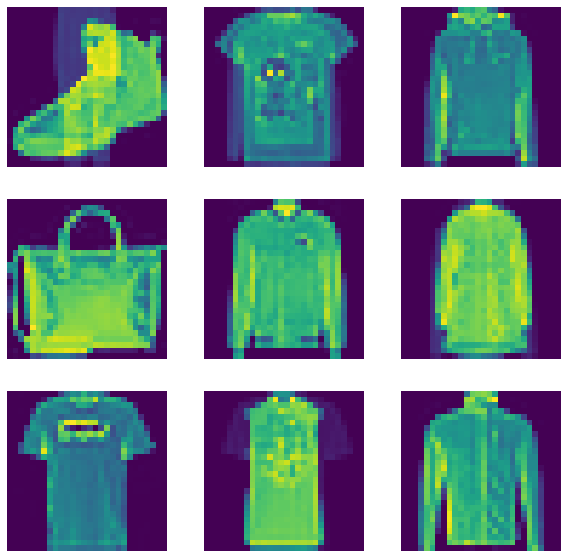

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Prepare dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

# Hyperparameters definition
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

# Data into TensorFlow Dataset objects
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# Mixupt technique function definition
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

# New augumented dataset visualisation
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

# Model building
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

# Model training with the mixed up dataset
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

# Model training without the mixed up dataset
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))




139264/127372 [================================] - 0s 0us/step


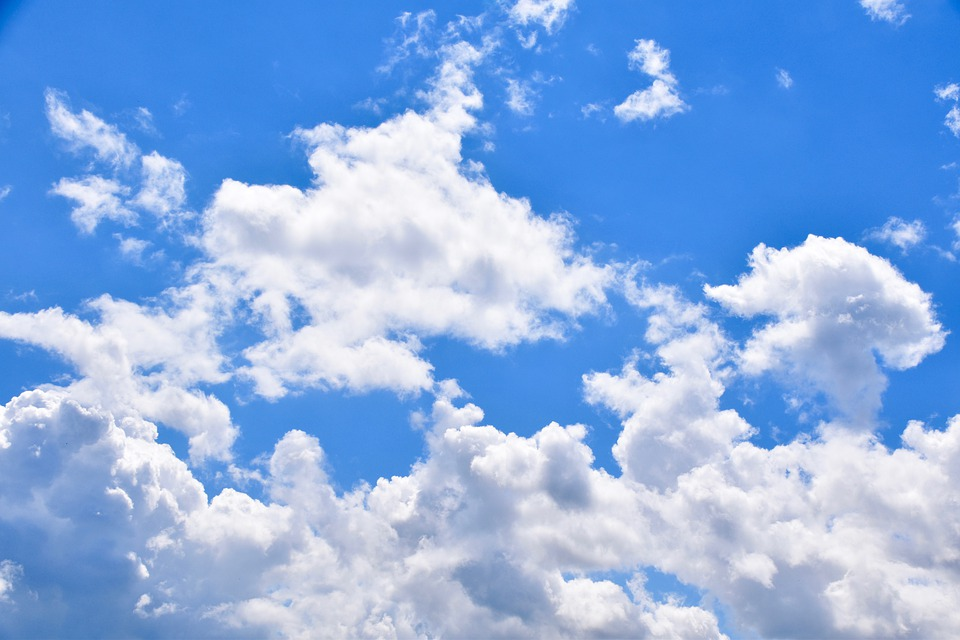

87924736/87910968 [==============================] - 1s 0us/step
Processing octave 0 with shape (326, 489)
... Loss value at step 0: 0.44
... Loss value at step 1: 0.62
... Loss value at step 2: 0.90
... Loss value at step 3: 1.24
... Loss value at step 4: 1.57
... Loss value at step 5: 1.91
... Loss value at step 6: 2.22
... Loss value at step 7: 2.53
... Loss value at step 8: 2.84
... Loss value at step 9: 3.13
... Loss value at step 10: 3.41
... Loss value at step 11: 3.66
... Loss value at step 12: 3.91
... Loss value at step 13: 4.17
... Loss value at step 14: 4.41
... Loss value at step 15: 4.64
... Loss value at step 16: 4.94
... Loss value at step 17: 5.16
... Loss value at step 18: 5.42
... Loss value at step 19: 5.63
Processing octave 1 with shape (457, 685)
... Loss value at step 0: 1.09
... Loss value at step 1: 1.76
... Loss value at step 2: 2.33
... Loss value at step 3: 2.81
... Loss value at step 4: 3.26
... Loss value at step 5: 3.69
... Loss value at step 6: 4.10
... 

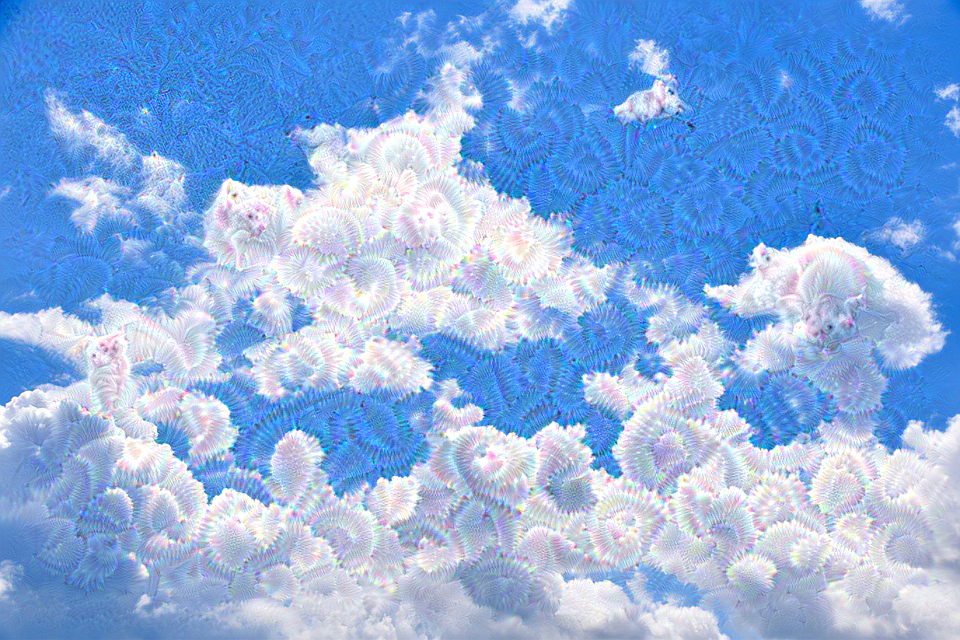

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("sky.jpg", "https://i.imgur.com/aGBdQyK.jpg")
result_prefix = "sky_dream"

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 15.0

from IPython.display import Image, display

display(Image(base_image_path))


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Computing the Deep Dream Loss

# Build an InceptionV3 model loaded with pre-trained ImageNet weights
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Set up a model that returns the activation values for every target layer
# (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img


original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))


display(Image(result_prefix + ".png"))